## Setup libs

In [1]:
import importlib
import brikasutils as bu
importlib.reload(bu)
import shared_utils as utils
from shared_utils import systemMsg, userMsg, assistantMsg
importlib.reload(utils)
import survey
importlib.reload(survey)
import persona
importlib.reload(persona)

import ollama
import numpy as np
from numpy.linalg import norm
import pandas as pd
import os
import re
import time
import json
from typing import List
from openai import OpenAI

# **Analysis**

### Batch analysis

In [2]:
import json
import os
import survey
import pandas as pd
import re
import importlib
import shared_utils as utils
importlib.reload(utils)
import brikasutils as bu
importlib.reload(bu)

def see_if_column_valid(column_name, df, msg="Verification failed for"):
    dff = df[df[column_name].isna()]
    dfff = dff.groupby("sim_signature").apply(lambda x: x[x['run_number'] == 1], include_groups=False)
    print(f"{msg}: {len(dff)} ({len(dfff)} unique)")
    return dfff

MOST_IMPORTANT_COLUMNS = ['sim_signature', 'run_number', "model", "survey_type", "base_sim_signature", "SUBJECT", 'CTX_limit', "retrieval method"]

In [3]:
# Index all simulation files
SIMULATIONS_DIR = "analysis/sims-final-2"

sim_runs = []
for root, dirs, files in os.walk(SIMULATIONS_DIR):
    for file in files:
        if file.split(".")[1] != "json":
            print(f"Invalid file (all must be json) {sim_run['path']}")

        sim_run = {}
        sim_run["SIMULATION_ID"] = file.split(".")[0]
        sim_run["path"] = os.path.join(root, file)
        with open(sim_run["path"], 'r') as f:
            sim = json.load(f)
        sim_run.update(sim["info"]["info"])
        sim_run.update(sim["info"]["settings"])
        sim_runs.append(sim_run)

df = pd.DataFrame(sim_runs)
df = df.dropna(axis=1, how='all')
print(f"Loaded {len(df)} simulation files")

Loaded 234 simulation files


### Infer/Get Needed Data

In [4]:
def infer_survey_type(row):
    if "survey_type" in row and not pd.isna(row["survey_type"]):
        if row["survey_type"] == "KanoSurvey":
            return "KanoSurvey"
        elif row["survey_type"] == "PersonalitySurvey":
            return "PersonalitySurvey"
        else:
            print("Unknown survey type" + row["survey_type"])

    if "prompt_count" in row and not pd.isna(row["prompt_count"]):
        if row["prompt_count"] == 50:
            return "PersonalitySurvey"
        elif row["prompt_count"] == 40:
            return "KanoSurvey"
        else:
            print("Unknown prompt count" + row["prompt_count"])

    return None

df["survey_type"] = df.apply(infer_survey_type, axis=1) 
df["survey_type"].value_counts()

# extract_run_number
def extract_run_number(sim_id):
    try:
        parts = sim_id.rsplit('_', 1)  # Attempt to split by the last underscore
        if len(parts) == 2:  # Check if the split was successful
            return pd.Series([parts[0], int(parts[-1])])
        else:
            print(f"Error while processing {sim_id}")
            return pd.Series([pd.NA, pd.NA])  # Return None for last_number if split fails
         
    except Exception as e:  # Generic exception handling
        print(f"Error while processing {sim_id}")
        return pd.Series([pd.NA, pd.NA])

df[['sim_signature', 'run_number']] = df['SIMULATION_ID'].apply(extract_run_number)

In [5]:
# infer_if_simulation_is_base
def infer_if_simulation_is_base(row):
    if row["sim_signature"][:4] == "base":
        return True
    return False
    
df["is_base"] = df.apply(infer_if_simulation_is_base, axis=1)

# Below: Vanity Print
dff = df[df["is_base"] == True]
dff = dff.sort_values(by=['sim_signature', 'run_number'])
dff = dff.dropna(axis=1, how='all')
dfff = dff.groupby("sim_signature").apply(lambda x: x[x['run_number'] == 1], include_groups=False)
print(f"Found {len(dff)} ({len(dfff)} unique) base simulations")

Found 18 (6 unique) base simulations


In [51]:
# Preview base
dfff

,,SIMULATION_ID,path,date,CHUNK_SIZE,OVERLAP_SIZE,CTX_limit,EMBED_MODEL,prompt method,retrieval method,RETRIEVAL_PROMPT,...,average_prompt_tokens,total_all_prompt_tokens,prompt_tokens_min,prompt_tokens_max,avg_tokens_in_prompt,model,timeout,survey_type,run_number,is_base
sim_signature,,,,,,,,,,,,,,,,,,,,,,
base-kano-29_llama3-70b_V7,109,base-kano-29_llama3-70b_V7_1,analysis/sims-final-2\base-kano-29_llama3-70b_...,2024-05-06_133115,75,3,31000,nomic-embed-text,IMPERSONATE,base,video game features,...,109,4345,104,117,109,llama3-70b,300,KanoSurvey,1,True
base-kano-29_llama3-8b_V7,112,base-kano-29_llama3-8b_V7_1,analysis/sims-final-2\base-kano-29_llama3-8b_V...,2024-05-06_111147,75,3,31000,nomic-embed-text,IMPERSONATE,base,video game features,...,109,4345,104,117,109,llama3-8b,300,KanoSurvey,1,True
base-kano-29_mixtral-8x22b_V7,115,base-kano-29_mixtral-8x22b_V7_1,analysis/sims-final-2\base-kano-29_mixtral-8x2...,2024-05-06_111021,75,3,31000,nomic-embed-text,IMPERSONATE,base,video game features,...,109,4345,104,117,109,mixtral-8x22b,300,KanoSurvey,1,True
base-pers-29_llama3-70b_V7,118,base-pers-29_llama3-70b_V7_1,analysis/sims-final-2\base-pers-29_llama3-70b_...,2024-05-06_141229,75,3,31000,nomic-embed-text,IMPERSONATE,base,openess conciousness extrovert aggreableness n...,...,97,4831,94,102,97,llama3-70b,300,PersonalitySurvey,1,True
base-pers-29_llama3-8b_V7,121,base-pers-29_llama3-8b_V7_1,analysis/sims-final-2\base-pers-29_llama3-8b_V...,2024-05-06_111124,75,3,31000,nomic-embed-text,IMPERSONATE,base,openess conciousness extrovert aggreableness n...,...,97,4831,94,102,97,llama3-8b,300,PersonalitySurvey,1,True
base-pers-29_mixtral-8x22b_V7,124,base-pers-29_mixtral-8x22b_V7_1,analysis/sims-final-2\base-pers-29_mixtral-8x2...,2024-05-06_062133,75,3,31000,nomic-embed-text,IMPERSONATE,base,openess conciousness extrovert aggreableness n...,...,97,4831,94,102,97,mixtral-8x22b,300,PersonalitySurvey,1,True


In [6]:
# Map simulations to their base
def map_simulation_to_base(row):
    if row["is_base"] == True:
        return "(base)"
    if row["survey_type"] == "KanoSurvey" and row["model"] == "gpt-3.5-turbo":
        return "base_kano_v2_gpt35"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "gpt-3.5-turbo":
        return "base_personality_v2_gpt35"

    if row["survey_type"] == "KanoSurvey" and row["model"] == "llama3-70b":
        return "base-kano-29_llama3-70b_V7"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "llama3-70b":
        return "base-pers-29_llama3-70b_V7"
    
    if row["survey_type"] == "KanoSurvey" and row["model"] == "llama3-8b":
        return "base-kano-29_llama3-8b_V7"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "llama3-8b":
        return "base-pers-29_llama3-8b_V7"
    
    if row["survey_type"] == "KanoSurvey" and row["model"] == "mixtral-8x22b":
        return "base-kano-29_mixtral-8x22b_V7"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "mixtral-8x22b":
        return "base-pers-29_mixtral-8x22b_V7"
    
    return pd.NA
    
df["base_sim_signature"] = df.apply(map_simulation_to_base, axis=1)
dff = see_if_column_valid("base_sim_signature", df, "Missing mappings")
if len(dff) == 0:
    print("All mappings are valid")
else:
    print("Not all mappings are valid. See the missing mappings below")
    display(dff)

def infer_subject(row):
    if row["is_base"]:
        return "(base)"
    if "SUBJECT" in row and pd.notna(row["SUBJECT"]):
        if row["SUBJECT"] == "airidas" or row["SUBJECT"] == "Airidas" or row["SUBJECT"] == "airi":
            return "airidas"
        if row["SUBJECT"] == "elias" or row["SUBJECT"] == "eli":
            return "elias"
        print(f"Unknown subject: {row['SUBJECT']}")
        return pd.NA
    if "subject" in row and pd.notna(row["subject"]):
        if row["subject"] == "airidas" or row["subject"] == "Airidas" or row["subject"] == "airi":
            return "airidas"
        if row["subject"] == "elias" or row["subject"] == "eli":
            return "elias"
        print(f"Unknown subject: {row['subject']}")
        return pd.NA
    if row["sim_signature"][:4] == "airi":
        return "airidas"
    if row["sim_signature"][:3] == "eli":
        return "elias"
    return pd.NA

df["SUBJECT"] = df.apply(infer_subject, axis=1)
dff = see_if_column_valid("SUBJECT", df, "Missing subjects")
if len(dff) == 0:
    print("All subjects are valid")
else:
    display(dff)

df = utils.bring_to_front_important_columns(df, MOST_IMPORTANT_COLUMNS)


Missing mappings: 0 (0 unique)
All mappings are valid
Missing subjects: 0 (0 unique)
All subjects are valid


### Compute Scores

#### Setup

In [52]:
er = [] # Extraction records

In [33]:
def get_surv_from_info(row):
    if row["survey_type"] == "KanoSurvey":
        return survey.KanoSurvey()
    elif row["survey_type"] == "PersonalitySurvey":
        return survey.PersonalitySurvey()
    else:
        raise Exception("Unknown survey type: " + row["survey_type"])

all_possible_asnwers = ["I LIKE IT", "I EXPECT IT", "I AM NEUTRAL", "I CAN TOLERATE IT", "I DISLIKE IT", "SOMEWHAT DISAGREE", "DISAGREE", "NEUTRAL", "SOMEWHAT AGREE", "AGREE"]
def extract_possible_answer(value):
    for phrase in all_possible_asnwers:
        pattern = r'(?i)' + re.escape(phrase)
        match = re.search(pattern, value)
        if match:
            # if value != phrase:
            #     er.append([value, phrase])  
            return match.group()
    return value  # Return the original value if no possible answer is found

############ Invalid Answers ##################
def get_invalid_answers(value):
    if pd.isna(value):
        return ""
    elif value == "NaN":
        return ""
    elif value in all_possible_asnwers:
        return ""
    else:
        return value

def clean_simulation_QA(df) -> pd.DataFrame:
    df['answer'] = df['answer'].apply(lambda x: x.strip())
    for substr in utils.BLACKLIST_ANSWER_SUBSTRINGS:
        df['answer'] = df['answer'].apply(lambda x: re.sub(substr, "", x))
    df['answer'] = df['answer'].str.upper()
    df['answer'] = df['answer'].apply(extract_possible_answer)

    REMAP_MISSING_E = {"AGRE": "AGREE", "SOMEWHAT AGRE": "SOMEWHAT AGREE", "SOMEWHAT DISAGRE": "SOMEWHAT DISAGREE", "DISAGRE": "DISAGREE", "I DON'T LIKE IT": "I DISLIKE IT"}
    df.iloc[:, 1:] = df.iloc[:, 1:].map(lambda x: REMAP_MISSING_E.get(x, x))

    PARTIAL_MATCH_REMAP = {"SOMEWHAT AG":"SOMEWHAT AGREE" }
    df["answer"] = df["answer"].apply(
        lambda answer: next((value for key, value in PARTIAL_MATCH_REMAP.items() if key in answer), answer)
    )

    # Update isValid
    df['isValid'] = df['answer'].apply(lambda x: x in all_possible_asnwers)

    # if all values in isValid is true, drop the column, else print a message
    if not df['isValid'].all():
        print("Warning, some answers were not valid. See df['isValid']")      

    return df

# Proces simulation output
def add_airidas_and_elias_answers(df, surv) -> pd.DataFrame:
    # Add airidas and elias answers
    air = surv.test_answers["airidas"]
    eli = surv.test_answers["elias"]

    # Sanity Check
    if len(air) != len(df):
        raise Exception(f"Survey and DF length mismatch {len(air)} != {len(df)}. Suvey type: {str(type(surv))}")

    df.insert(2, "airidas", air[:len(df)])
    df.insert(3, "elias", eli[:len(df)])

    # Convert to uppercase
    if isinstance(surv, survey.KanoSurvey):
        df['answer'] = df['answer'].str.upper()
        df['airidas'] = df['airidas'].str.upper()
        df['elias'] = df['elias'].str.upper()
        
    return df

def remap_answers_to_integers(df, surv):
    if isinstance(surv, survey.KanoSurvey):
        remap_dict = {"I EXPECT IT": 5, "I LIKE IT": 4, "I AM NEUTRAL": 3, "I CAN TOLERATE IT": 2, "I DISLIKE IT": 1}
        df['answer'] = df['answer'].map(remap_dict)
        df['airidas'] = df['airidas'].map(remap_dict)
        df['elias'] = df['elias'].map(remap_dict)
    elif isinstance(surv, survey.PersonalitySurvey):
        remap_dict = {"AGREE": 5, "SOMEWHAT AGREE": 4, "NEUTRAL": 3, "SOMEWHAT DISAGREE": 2, "DISAGREE": 1}
        df['answer'] = df['answer'].map(remap_dict)

    return df

def evaluate_single_simulation_run(df) -> dict:
    # compute the percentage of correct answers and average loss (MAE)
    result_data = {
        "p-corr_Airidas": df['answer'].corr(df['airidas']),
        "p-corr_Elias": df['answer'].corr(df['elias']),
        # Average of absolute residuals for Airidas
        "MAE_airi": (df['answer'] - df['airidas']).abs().sum() / len(df),
        # Average of absolute residuals for Elias
        "MAE_eli": (df['answer'] - df['elias']).abs().sum() / len(df),
        "question_count": len(df),
    }
    return result_data


ADD_TO_MOST_IMPORTANT_COLUMNS = ["MAE_airi", "MAE_eli"]
for col in ADD_TO_MOST_IMPORTANT_COLUMNS:
    if col not in MOST_IMPORTANT_COLUMNS:
        MOST_IMPORTANT_COLUMNS.append(col)  

#### Multi-Sim

In [8]:
# df = df[df['model'] != 'mixtral-8x22b']

In [44]:
EVALUATE_INVALID_SIMULATIONS = True
invalid_vals = []
tmp = []

for index, sim_row in df.iterrows():
    sim = utils.load_sim(sim_row["path"])
    dfQA = utils.dataframe_from_QA(sim["QA"])
    with bu.MutePrint():
        surv = get_surv_from_info(sim_row)
        dfQA = clean_simulation_QA(dfQA)
    dfQA = add_airidas_and_elias_answers(dfQA, surv)

    ## Check for invalid values
    if not dfQA['isValid'].all():
        invalid_vals.extend(dfQA.loc[~dfQA['isValid'], 'answer'].tolist())
        
        if EVALUATE_INVALID_SIMULATIONS:
            print(f"{sim_row['SIMULATION_ID']} has invalid value(s). Sim will be included with dropped rows.")
            dfQA = dfQA[dfQA['isValid'] == True]
        else:
            print(f"Skipping {sim_row['SIMULATION_ID']} due to invalid answers")
            continue


    dfQA = remap_answers_to_integers(dfQA, surv)
    res = evaluate_single_simulation_run(dfQA)

    for key, value in res.items():
        df.at[index, key] = round(value, 3)

# Rename values
df['CTX_limit'] = df['CTX_limit'].astype(str)
df.loc[df['CTX_limit'] == 0, 'CTX_limit'] = '1-chunk'

df = utils.bring_to_front_important_columns(df, MOST_IMPORTANT_COLUMNS)

if len(invalid_vals) > 0:
    print(f"{len(invalid_vals)} Invalid values:")
    display(pd.DataFrame(invalid_vals, columns=["Invalid Values"]))
    if EVALUATE_INVALID_SIMULATIONS:
        print("EVALUATE_INVALID_SIMULATIONS == True. All invalid values were dropped")
else:
    print("All values are valid")

airidas-pers-4000_mixtral-8x22b_V7_2 has invalid value(s). Sim will be included with dropped rows.
airidas-pers-7500_mixtral-8x22b_V7_0 has invalid value(s). Sim will be included with dropped rows.
eli-pers-dynamic-7500_mixtral-8x22b_V8_0 has invalid value(s). Sim will be included with dropped rows.
eli-pers-dynamic-7500_mixtral-8x22b_V8_1 has invalid value(s). Sim will be included with dropped rows.
eli-pers-dynamic-7500_mixtral-8x22b_V8_2 has invalid value(s). Sim will be included with dropped rows.
5 Invalid values:


,Invalid Values
0,IT SEEMS THAT YOU HAVE A TEXT-BASED CONVERSATI...
1,IT SEEMS LIKE YOU ARE PROVIDING A SERIES OF ME...
2,THE CONVERSATION IS BETWEEN TWO FRIENDS DISCUS...
3,IT SEEMS LIKE YOU ARE LOOKING FOR A WAY TO CON...
4,IT SEEMS LIKE YOU AND YOUR FRIEND ARE DISCUSSI...


EVALUATE_INVALID_SIMULATIONS == True. All invalid values were dropped


In [47]:
# Define how columns should be groped
aggregation_dict = {

    'MAE_airi': ['mean', 'std'],
    'MAE_eli': ['mean', 'std'],
    'run_number': ['count'],
    'question_count': ['min'],
    'p-corr_Airidas': ['mean', 'std'],
    'p-corr_Elias': ['mean', 'std'],
}
# Preserve the first entry of other columns
for col in df.columns:
    if col not in ['sim_signature', *list(aggregation_dict.keys())]:
        aggregation_dict[col] = 'first'
        
# dfg stands for DataFrame Grouped.
dfg = df.groupby('sim_signature').agg(aggregation_dict)

# Renaming MultiIndex columns
dfg.columns = ['_'.join(col).strip() if col[1] != 'first' else col[0] for col in dfg.columns.values]
dfg.rename(columns={'run_number_count': 'n-runs'}, inplace=True)

dfg = dfg.reset_index()
print(f"Total unique simulations: {len(dfg)}")
dfg.head(5)

Total unique simulations: 78


,sim_signature,MAE_airi_mean,MAE_airi_std,MAE_eli_mean,MAE_eli_std,n-runs,question_count_min,p-corr_Airidas_mean,p-corr_Airidas_std,p-corr_Elias_mean,...,path,SIMULATION_ID,mean_residual_Airidas,mean_residual_Elias,prompt_tokens_min,date,CHUNK_SIZE,OVERLAP_SIZE,chunk_count,CHUNKS_COUNT_IN_CTX
0,airidas-kano-0_llama3-70b_V7,0.775000,0.050000,1.083333,0.028868,3,40.0,0.572000,0.043347,0.280333,...,analysis/sims-final-2\airidas-kano-0_llama3-70...,airidas-kano-0_llama3-70b_V7_0,0.725,1.050,966,2024-05-06_025124,75,3,1.0,0.0
1,airidas-kano-0_llama3-8b_V7,0.991667,0.038188,1.066667,0.062915,3,40.0,0.361000,0.064257,0.266333,...,analysis/sims-final-2\airidas-kano-0_llama3-8b...,airidas-kano-0_llama3-8b_V7_0,1.000,1.075,966,2024-05-06_062545,75,3,1.0,0.0
2,airidas-kano-0_mixtral-8x22b_V7,0.725000,0.075000,1.033333,0.038188,3,40.0,0.631667,0.062389,0.251333,...,analysis/sims-final-2\airidas-kano-0_mixtral-8...,airidas-kano-0_mixtral-8x22b_V7_0,0.650,1.075,966,2024-05-06_144956,75,3,1.0,0.0
3,airidas-kano-4000_llama3-70b_V7,0.858333,0.052042,1.283333,0.052042,3,40.0,0.557000,0.034511,0.104333,...,analysis/sims-final-2\airidas-kano-4000_llama3...,airidas-kano-4000_llama3-70b_V7_0,0.875,1.300,2165,2024-05-06_045919,75,3,3.0,4.0
4,airidas-kano-4000_llama3-8b_V7,0.983333,0.162660,1.008333,0.072169,3,40.0,0.341667,0.164634,0.300333,...,analysis/sims-final-2\airidas-kano-4000_llama3...,airidas-kano-4000_llama3-8b_V7_0,1.150,0.925,2165,2024-05-06_032423,75,3,3.0,4.0


### Vizualisation

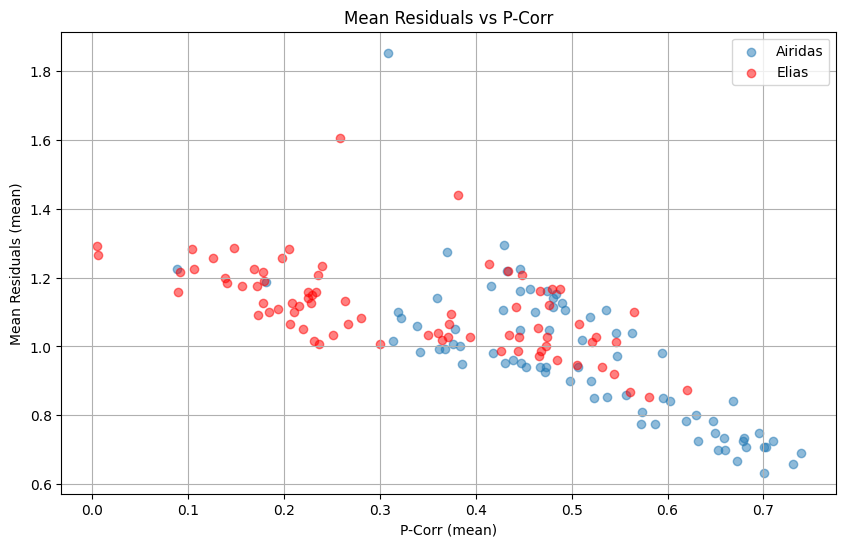

In [48]:
import matplotlib.pyplot as plt

# Assuming 'mean_residual_Airidas_mean' and 'p-corr_Airidas_mean' are already computed as mean values in your aggregated dataframe
# Plotting for Airidas
plt.figure(figsize=(10, 6))
plt.scatter(dfg['p-corr_Airidas_mean'], dfg['MAE_airi_mean'], label='Airidas', alpha=0.5)

# Assuming 'mean_residual_Elias_mean' and 'p-corr_Elias_mean' are also computed as mean values
# Plotting for Elias
plt.scatter(dfg['p-corr_Elias_mean'], dfg['MAE_eli_mean'], color='red', label='Elias', alpha=0.5)

plt.title('Mean Residuals vs P-Corr')
plt.xlabel('P-Corr (mean)')
plt.ylabel('Mean Residuals (mean)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_13932\2354292823.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, y=ylabel, x='MAE_airi_mean' if 'Airidas' in title else 'MAE_eli_mean', ax=ax, palette=colors, orient='h')
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_13932\2354292823.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, y=ylabel, x='MAE_airi_mean' if 'Airidas' in title else 'MAE_eli_mean', ax=ax, palette=colors, orient='h')
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_13932\2354292823.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=Fa

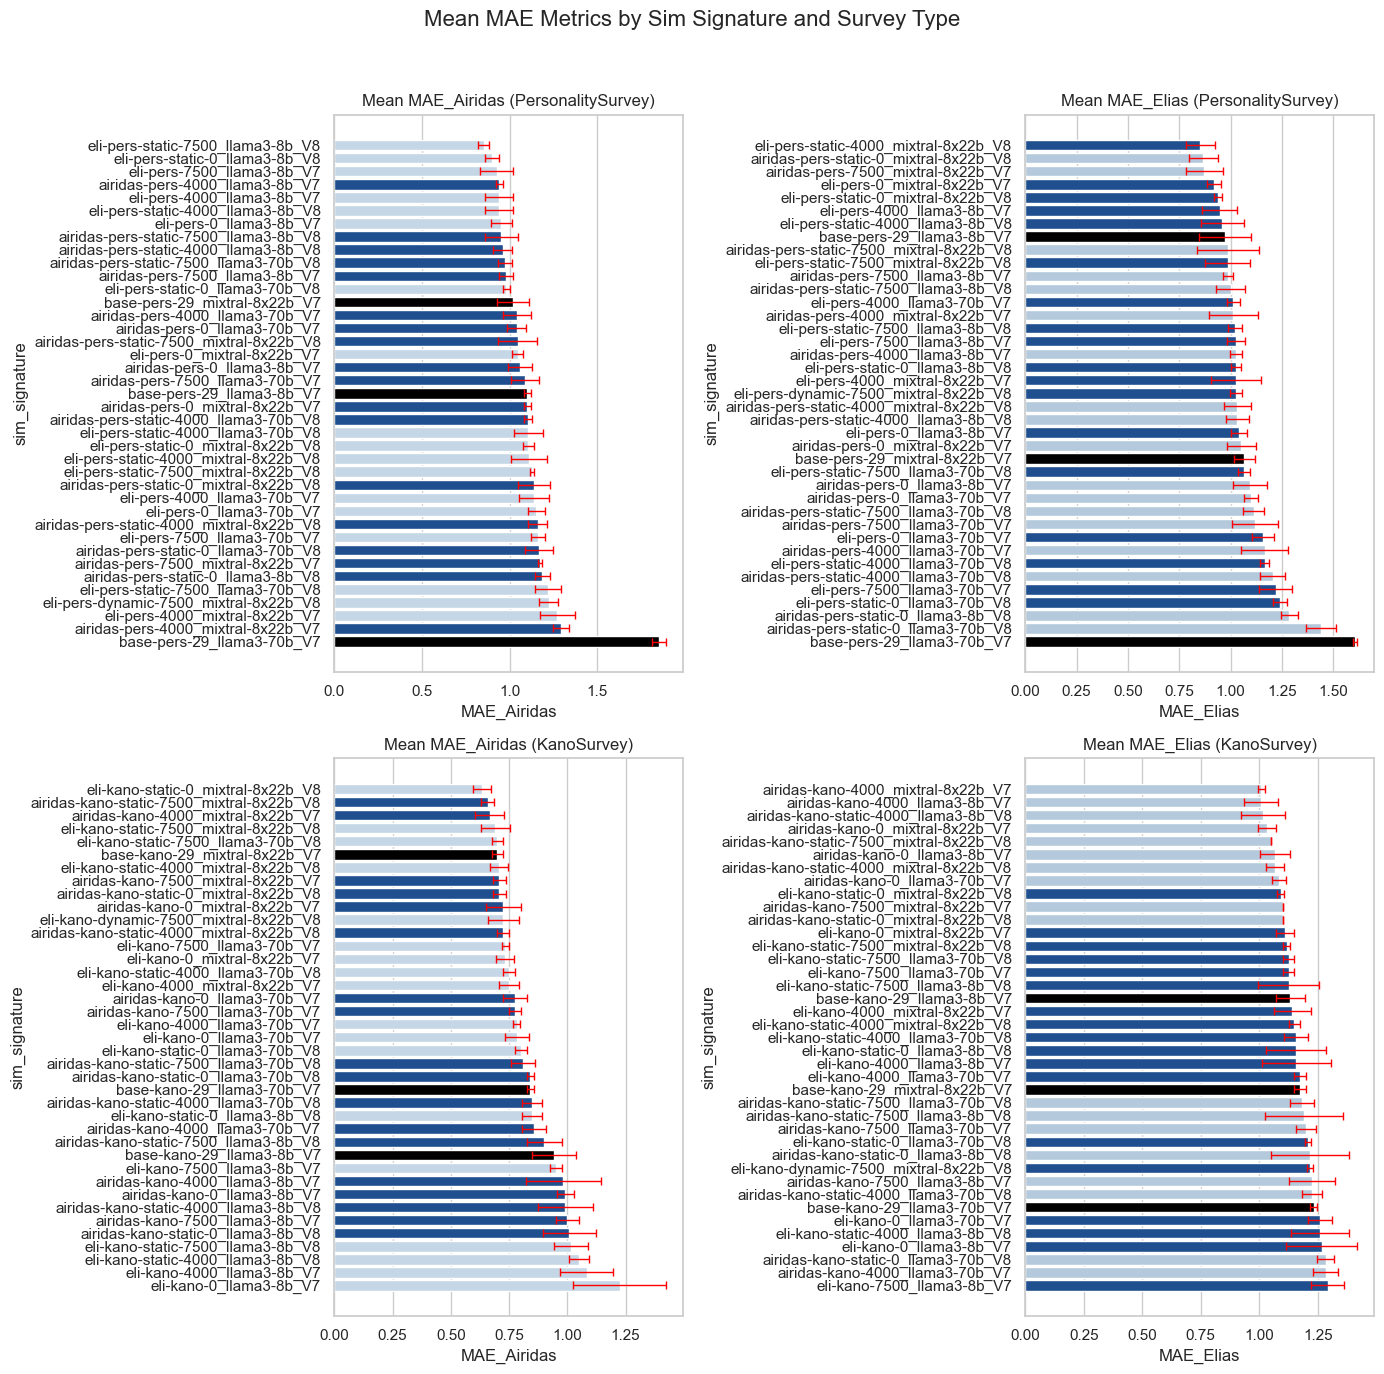

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style
sns.set(style="whitegrid")

# Sorting and filtering the dataframe for each plot
sorted_airidas_personality = dfg[(dfg['survey_type'] == 'PersonalitySurvey')].sort_values('MAE_airi_mean', ascending=True)
sorted_airidas_kano = dfg[(dfg['survey_type'] == 'KanoSurvey')].sort_values('MAE_airi_mean', ascending=True)
sorted_elias_personality = dfg[(dfg['survey_type'] == 'PersonalitySurvey')].sort_values('MAE_eli_mean', ascending=True)
sorted_elias_kano = dfg[(dfg['survey_type'] == 'KanoSurvey')].sort_values('MAE_eli_mean', ascending=True)

# Custom color functions
def get_colors_airidas(df):
    colors = []
    for _, row in df.iterrows():
        if row['SUBJECT'] != 'airidas' and not row['is_base']:
            colors.append('#bfd7ec')
        elif row['is_base']:
            colors.append('black')
        else:
            colors.append('#0c4da2')
    return colors

def get_colors_elias(df):
    colors = []
    for _, row in df.iterrows():
        if row['SUBJECT'] != 'elias' and not row['is_base']:
            colors.append('#adcbe3')
        elif row['is_base']:
            colors.append('black')
        else:
            colors.append('#0c4da2')
    return colors

colors_airidas_p = get_colors_airidas(sorted_airidas_personality)
colors_airidas_k = get_colors_airidas(sorted_airidas_kano)
colors_elias_p = get_colors_elias(sorted_elias_personality)
colors_elias_k = get_colors_elias(sorted_elias_kano)

fig, axs = plt.subplots(2, 2, figsize=(14, 14))
fig.suptitle('Mean MAE Metrics by Sim Signature and Survey Type', fontsize=16)

# Adding horizontal bars and error bars
for (data, ax, colors, ylabel, title) in [
    (sorted_airidas_personality, axs[0, 0], colors_airidas_p, 'sim_signature', 'Mean MAE_Airidas (PersonalitySurvey)'),
    (sorted_airidas_kano, axs[1, 0], colors_airidas_k, 'sim_signature', 'Mean MAE_Airidas (KanoSurvey)'),
    (sorted_elias_personality, axs[0, 1], colors_elias_p, 'sim_signature', 'Mean MAE_Elias (PersonalitySurvey)'),
    (sorted_elias_kano, axs[1, 1], colors_elias_k, 'sim_signature', 'Mean MAE_Elias (KanoSurvey)')
]:
    sns.barplot(data=data, y=ylabel, x='MAE_airi_mean' if 'Airidas' in title else 'MAE_eli_mean', ax=ax, palette=colors, orient='h')
    if 'Airidas' in title:
        ax.errorbar(data['MAE_airi_mean'], data[ylabel], xerr=data['MAE_airi_std'], fmt='none', ecolor='red', capsize=3, elinewidth=1, alpha=1 )
    else:
        ax.errorbar(data['MAE_eli_mean'], data[ylabel], xerr=data['MAE_eli_std'], fmt='none', ecolor='red', capsize=3, elinewidth=1, alpha=1)
    ax.set_title(title)
    ax.set_xlabel(title.split(' ')[1])
    ax.set_ylabel(ylabel)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

###########################
# Average the crossed results
###########################

In [67]:
# expoert dfg to csv
dfg.to_csv("analysis/spreadsheets/dfg-1.csv", index=False)

In [40]:
len(dfg)

61

### Hyperparameter tuning analysis (NEW)

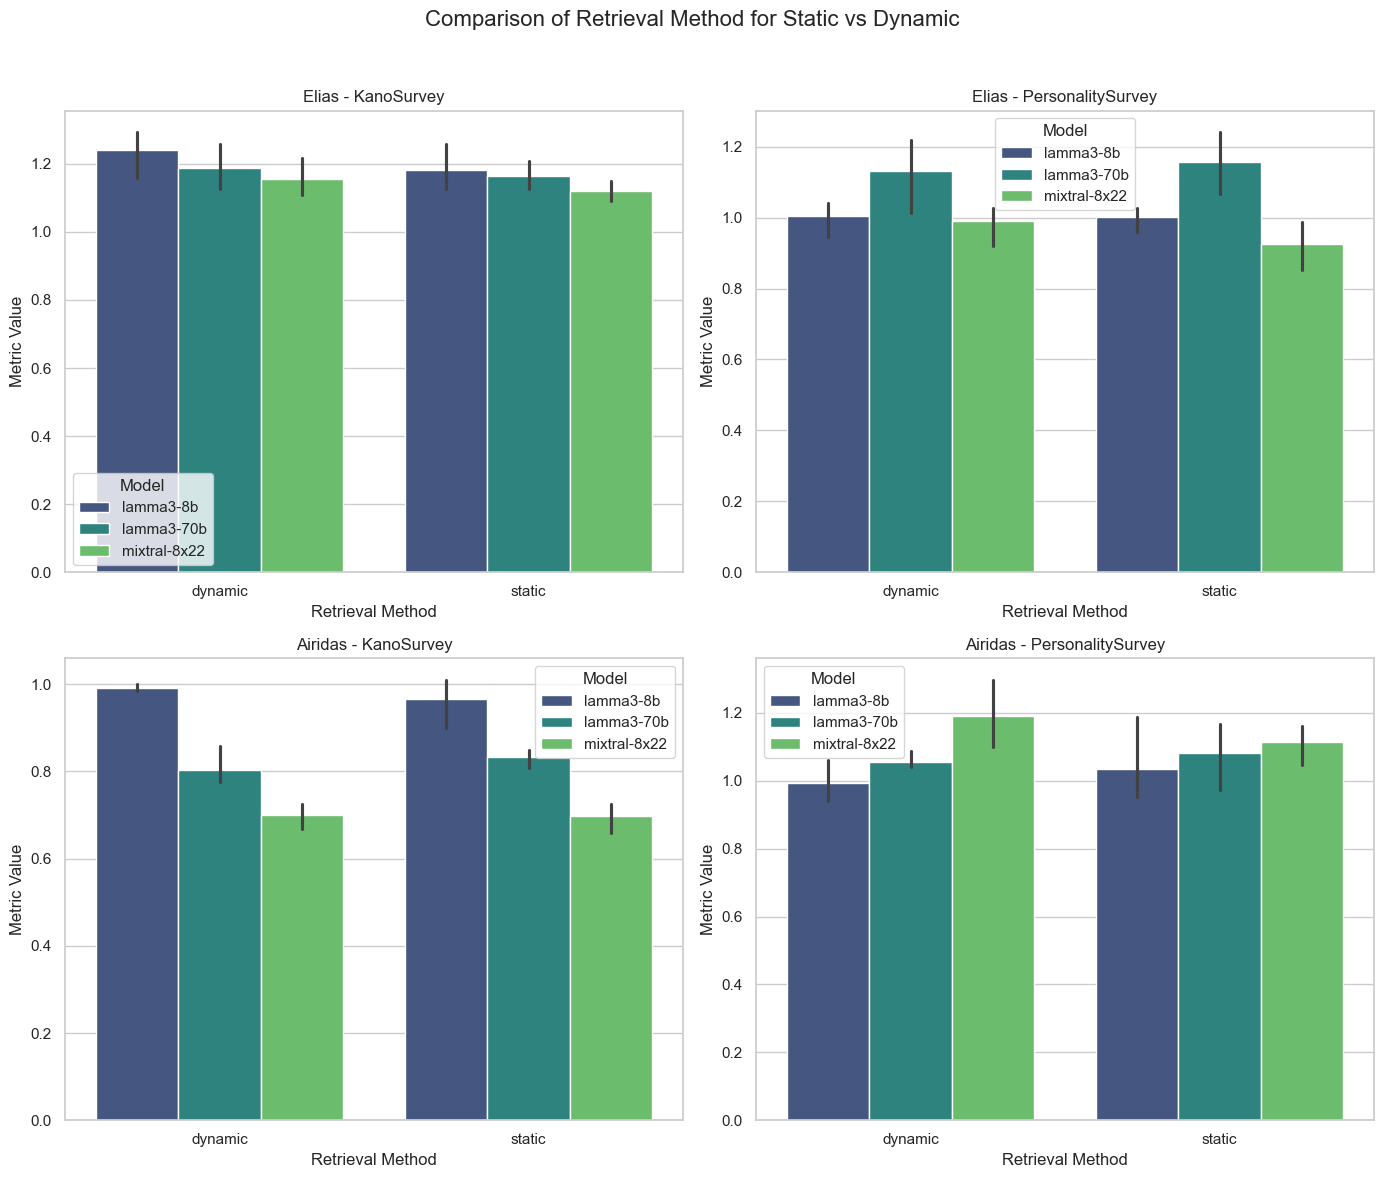

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'dfg' is your DataFrame
# Filter out rows where 'is_base' is True
df_filtered = dfg[dfg['is_base'] == False]

# Create a figure for the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns
fig.suptitle('Comparison of Models for Static vs Dynamic (Lower is better)', fontsize=16)

# Each subplot for different combinations
for i, (subject, survey_type) in enumerate([
        ('elias', 'KanoSurvey'), ('elias', 'PersonalitySurvey'),
        ('airidas', 'KanoSurvey'), ('airidas', 'PersonalitySurvey')]):

    ax = axs[i//2, i%2]
    
    # Filter data for the specific group
    df_group = df_filtered[(df_filtered['SUBJECT'] == subject) & (df_filtered['survey_type'] == survey_type)]
    
    # Separate further by model
    df_group_8b = df_group[df_group['model'] == 'llama3-8b']
    df_group_70b = df_group[df_group['model'] == 'llama3-70b']
    df_group_8x22b = df_group[df_group['model'] == 'mixtral-8x22b']
    
    # Combine the data for a comparison by retrieval method and model
    df_group_8b = df_group_8b.assign(Model='lamma3-8b')
    df_group_70b = df_group_70b.assign(Model='lamma3-70b')
    df_group_8x22b = df_group_8x22b.assign(Model='mixtral-8x22')
    df_plot = pd.concat([df_group_8b, df_group_70b, df_group_8x22b])

    # Select the correct metric based on the subject
    if subject == 'elias':
        metric_column = f'MAE_eli_mean'
    if subject == 'airidas':
        metric_column = f'MAE_airi_mean'
    df_plot['Metric Value'] = df_plot[metric_column]
    
    # Create a bar chart
    sns.barplot(data=df_plot, x='retrieval method', y='Metric Value', hue='Model', ax=ax, palette='viridis')
    
    # Setting the title and labels
    ax.set_title(f'{subject.capitalize()} - {survey_type}')
    ax.set_xlabel('Retrieval Method')
    ax.set_ylabel('Metric Value')

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()


##########################
# Add base
#########################

C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_9212\3737665853.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['Metric Value'] = df_group[metric_column]
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_9212\3737665853.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['Metric Value'] = df_group[metric_column]
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_9212\3737665853.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

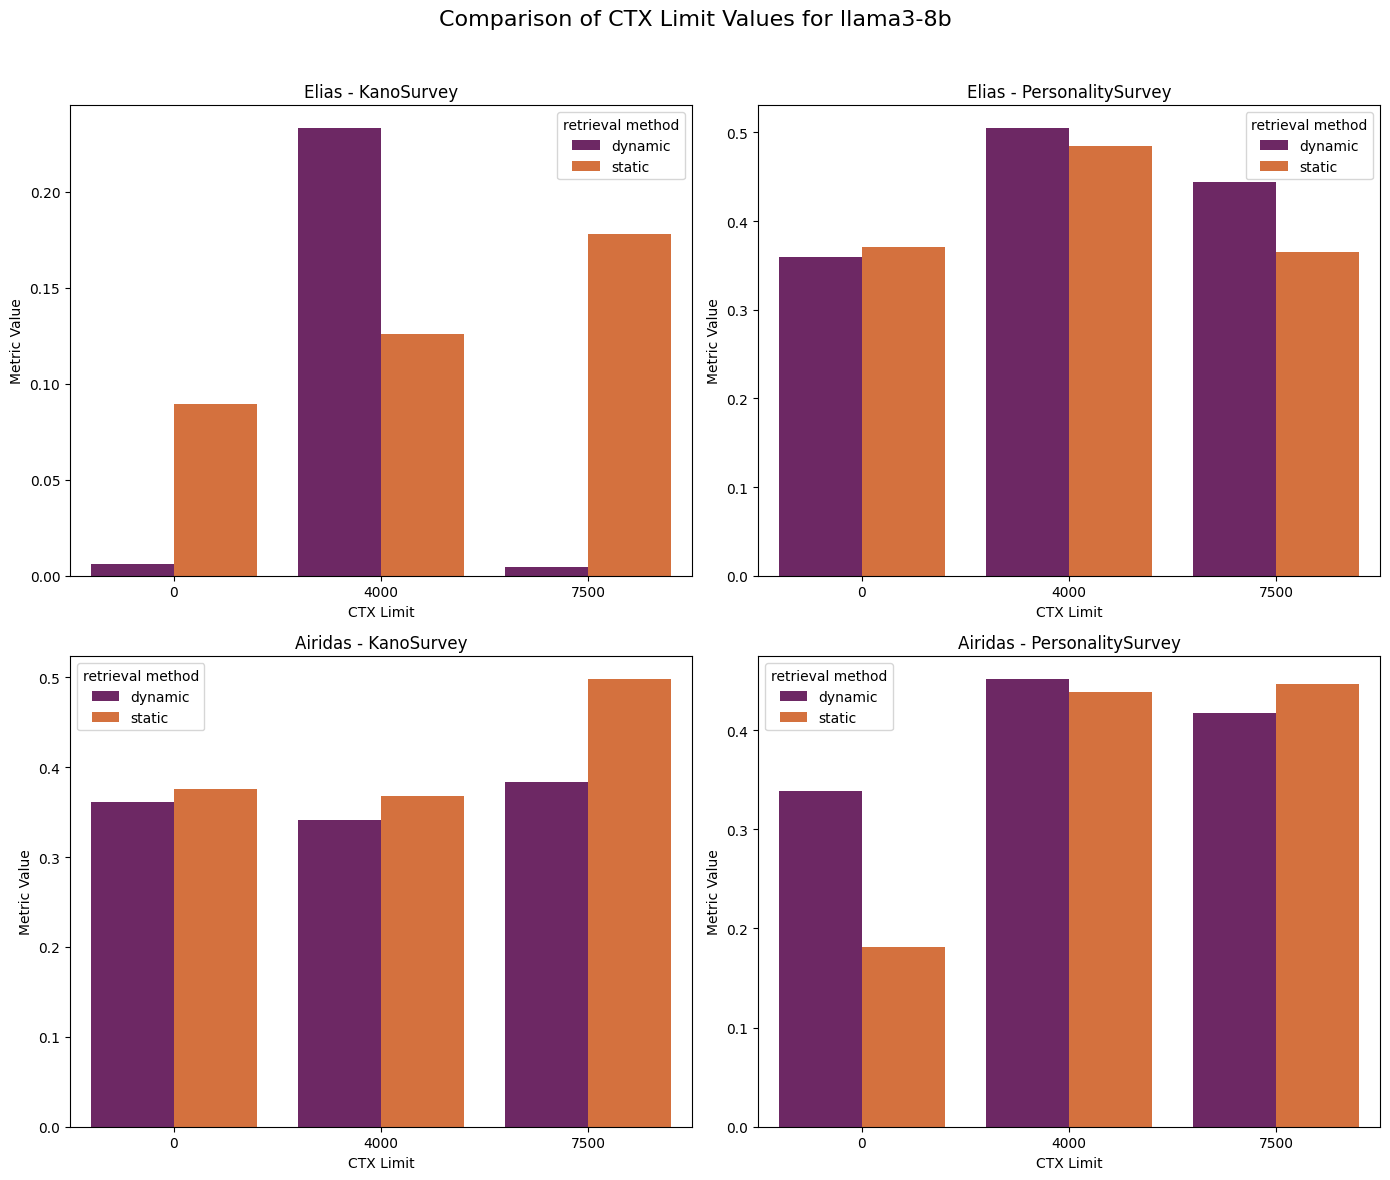

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'dfg' is your DataFrame
# Filter out rows where 'is_base' is True and 'lamma3-70b'

df_filtered = dfg[(dfg['is_base'] == False) & (dfg['model'] == 'llama3-8b')]

# Create a figure for the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns
fig.suptitle('Comparison of CTX Limit Values for llama3-8b', fontsize=16)

# Each subplot for different combinations
for i, (subject, survey_type) in enumerate([
        ('elias', 'KanoSurvey'), ('elias', 'PersonalitySurvey'),
        ('airidas', 'KanoSurvey'), ('airidas', 'PersonalitySurvey')]):

    ax = axs[i//2, i%2]
    
    # Filter data for the specific group
    df_group = df_filtered[(df_filtered['SUBJECT'] == subject) & (df_filtered['survey_type'] == survey_type)]
    
    # Select the correct metric based on the subject
    metric_column = f'p-corr_{subject.capitalize()}_mean'
    df_group['Metric Value'] = df_group[metric_column]
    
    # Create a bar chart
    sns.barplot(data=df_group, x='CTX_limit', y='Metric Value', hue='retrieval method', ax=ax, palette= "inferno")
    
    # Setting the title and labels
    ax.set_title(f'{subject.capitalize()} - {survey_type}')
    ax.set_xlabel('CTX Limit')
    ax.set_ylabel('Metric Value')

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()

### Hyperparameter tuning analysis

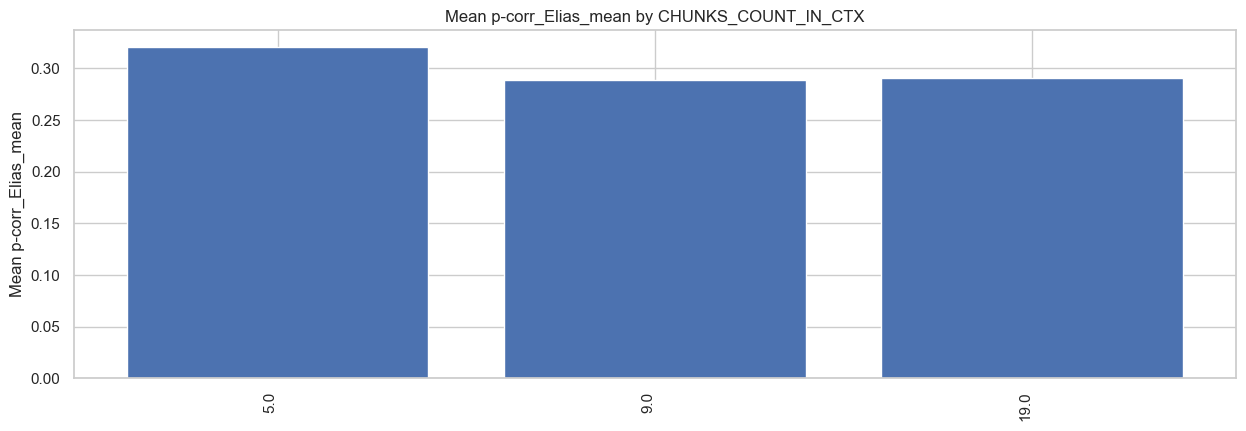

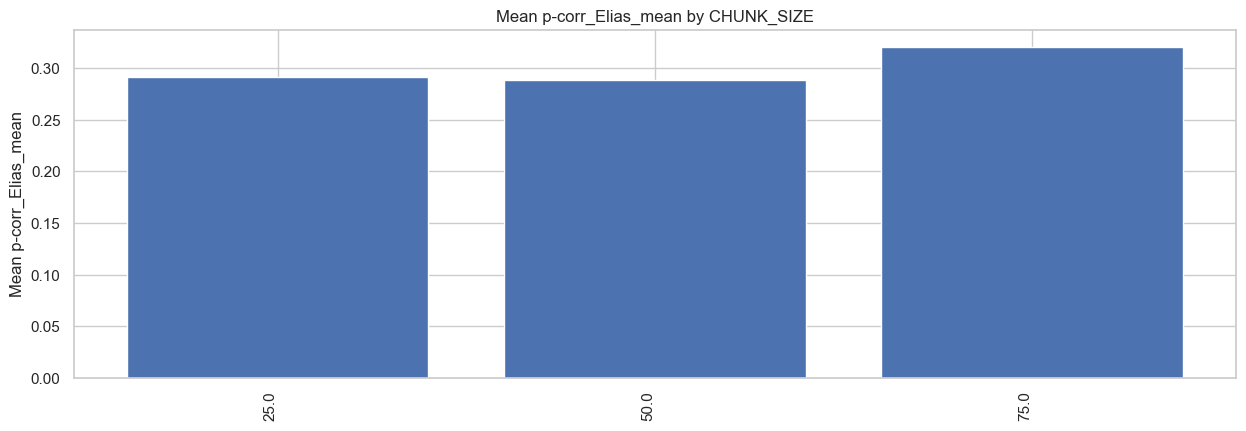

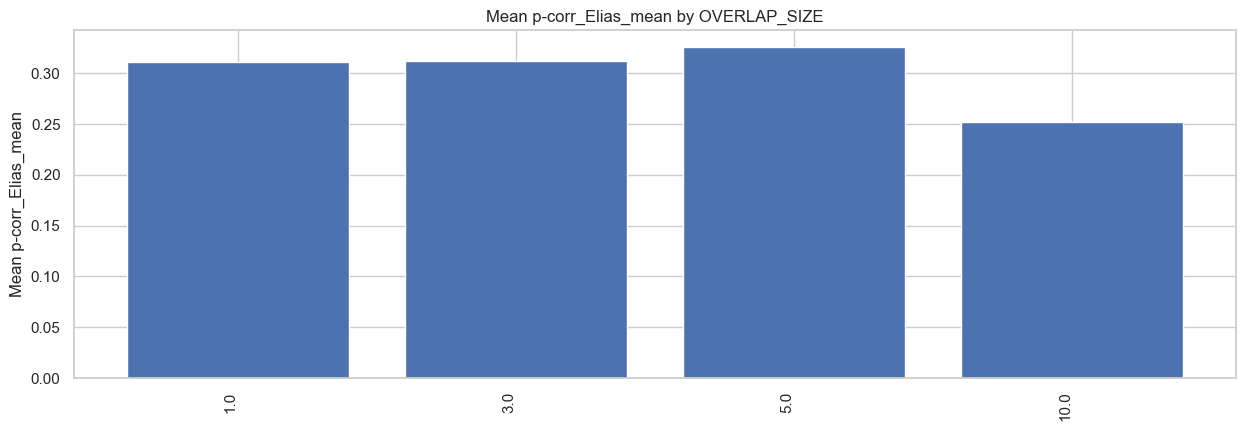

In [25]:
import matplotlib.pyplot as plt
import numpy as np
dfg = dfg[dfg['SUBJECT'] != "airidas"]
dfg = dfg[dfg['retrieval method'] == "dynamic"]
# Compute mean p-corr_Elias_mean for each unique value of 'CHUNKS_COUNT_IN_CTX'
chunks_count_means = dfg.groupby('CHUNKS_COUNT_IN_CTX')['p-corr_Elias_mean'].mean().reset_index()
chunks_count_means = chunks_count_means.sort_values(by='CHUNKS_COUNT_IN_CTX')

# Plot bar chart for 'CHUNKS_COUNT_IN_CTX'
plt.figure(figsize=(15, 6))
plt.bar(np.arange(len(chunks_count_means)), chunks_count_means['p-corr_Elias_mean'])
plt.xticks(np.arange(len(chunks_count_means)), chunks_count_means['CHUNKS_COUNT_IN_CTX'], rotation=90, ha='right')
plt.subplots_adjust(bottom=0.3)
plt.ylabel('Mean p-corr_Elias_mean')
plt.title('Mean p-corr_Elias_mean by CHUNKS_COUNT_IN_CTX')
plt.show()

# Compute mean p-corr_Elias_mean for each unique value of 'CHUNK_SIZE'
chunk_size_means = dfg.groupby('CHUNK_SIZE')['p-corr_Elias_mean'].mean().reset_index()
chunk_size_means = chunk_size_means.sort_values(by='CHUNK_SIZE')

# Plot bar chart for 'CHUNK_SIZE'
plt.figure(figsize=(15, 6))
plt.bar(np.arange(len(chunk_size_means)), chunk_size_means['p-corr_Elias_mean'])
plt.xticks(np.arange(len(chunk_size_means)), chunk_size_means['CHUNK_SIZE'], rotation=90, ha='right')
plt.subplots_adjust(bottom=0.3)
plt.ylabel('Mean p-corr_Elias_mean')
plt.title('Mean p-corr_Elias_mean by CHUNK_SIZE')
plt.show()

# Compute mean p-corr_Elias_mean for each unique value of 'OVERLAP_SIZE'
overlap_size_means = dfg.groupby('OVERLAP_SIZE')['p-corr_Elias_mean'].mean().reset_index()
overlap_size_means = overlap_size_means.sort_values(by='OVERLAP_SIZE')

# Plot bar chart for 'OVERLAP_SIZE'
plt.figure(figsize=(15, 6))
plt.bar(np.arange(len(overlap_size_means)), overlap_size_means['p-corr_Elias_mean'])
plt.xticks(np.arange(len(overlap_size_means)), overlap_size_means['OVERLAP_SIZE'], rotation=90, ha='right')
plt.subplots_adjust(bottom=0.3)
plt.ylabel('Mean p-corr_Elias_mean')
plt.title('Mean p-corr_Elias_mean by OVERLAP_SIZE')
plt.show()

In [239]:
import matplotlib.pyplot as plt
import numpy as np

# Drop rows where SUBJECT == "airidas"
dfg = dfg[dfg['SUBJECT'] != "airidas"]
dfg = dfg[dfg['retrieval method'] == "dynamic"]
# dfg = dfg[dfg['survey_type'] != "PersonaSurvey"]

# Compute mean p-corr_Elias_mean for each unique value of 'retrieval_method'
retrieval_method_means = dfg.groupby('retrieval method')['p-corr_Elias_mean'].mean().reset_index()
retrieval_method_means = retrieval_method_means.sort_values(by='retrieval method')

# Plot bar chart for 'retrieval_method'
plt.figure(figsize=(15, 6))
plt.bar(np.arange(len(retrieval_method_means)), retrieval_method_means['p-corr_Elias_mean'])
plt.xticks(np.arange(len(retrieval_method_means)), retrieval_method_means['retrieval method'], rotation=90, ha='right')
plt.subplots_adjust(bottom=0.3)
plt.ylabel('Mean p-corr_Elias_mean')
plt.title('Mean p-corr_Elias_mean by Retrieval Method')
plt.show()

KeyError: 'SUBJECT'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Drop rows where SUBJECT == "airidas"
dfg = dfg[dfg['SUBJECT'] != "airidas"]


# Compute mean p-corr_Elias_mean and mean_residual_Elias_std for each unique value of 'retrieval_method'
retrieval_method_means = dfg.groupby('retrieval method')[['p-corr_Elias_mean', 'mean_residual_Elias_std']].mean().reset_index()
retrieval_method_means = retrieval_method_means.sort_values(by='retrieval method')

# Plot bar chart for 'retrieval_method'
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.35
index = np.arange(len(retrieval_method_means))

rects1 = ax.bar(index, retrieval_method_means['p-corr_Elias_mean'], bar_width, label='p-corr_Elias_mean')
rects2 = ax.bar(index + bar_width, retrieval_method_means['mean_residual_Elias_std'], bar_width, label='mean_residual_Elias_std')

ax.set_xlabel('Retrieval Method')
ax.set_ylabel('Mean Value')
ax.set_title('Mean Values by Retrieval Method')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(retrieval_method_means['retrieval method'], rotation=90, ha='right')
ax.legend()

fig.tight_layout()
plt.show()

In [16]:
import pandas as pd
# Drop rows where SUBJECT == "airidas"
# dfg = dfg[dfg['SUBJECT'] != "airidas"]
# Compute summary statistics for each retrieval method
summary_stats = dfg.groupby('retrieval method')[['p-corr_Elias_mean', 'mean_residual_Elias_std']].agg(['mean', 'var', 'std'])
# Reset the multi-index to make the column labels more readable
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
summary_stats = summary_stats.reset_index()
# Store the summary statistics in a DataFrame
pd.DataFrame(summary_stats)

,retrieval method,p-corr_Elias_mean_mean,p-corr_Elias_mean_var,p-corr_Elias_mean_std,mean_residual_Elias_std_mean,mean_residual_Elias_std_var,mean_residual_Elias_std_std
0,base,0.306750,0.011282,0.106217,0.053978,0.002926,0.054095
1,dynamic,0.312194,0.028308,0.168249,0.065168,0.001424,0.037734
2,static,0.289597,0.019954,0.141257,0.068373,0.002071,0.045509


In [ ]:
systemMsg( "You are participating in a survey. You will be presented with a series of questions about your video game preferrences.", f"You must choose answer to the question below with one of the five options: {', '.join(surv.POSSIBLE_ANSWERS)}. The answer must only contain the chosen option. " ), 
# Understanding affirmation 
assistantMsg('Understood. I will answer the question below with one of the given options.'), 
# Survey question. With Simulation 
userMsg( question, "Your choice: " ),

systemMsg("\\n".join([
            f"You are an expert actor, specializing in impersonation of non-famouns people. You will be presented to the subject through explicit datapoints of their digital footprint. In addition, you will deduct their implicit {SURVEY} by shadowing chats between the subject and friends. You will be asked to fully immerse yourself in the role, and answer questions from the point of view of the persona. \\n#Context \\n##Chat conversations between the subject and their friends:\\n**From most to least related**\\n",
            "\\n\\nNEW CONVERSATION:\\n".join(chunks_most_similar)
        ])),      
        assistantMsg("Understood. I will answer from the point of view of the persona, based on what I could the deduct from the text provided."),
        userMsg("\\n".join([
            f"Persona is questioned about their {SURVEY} in an {METHOD}. The persona must choose an appropriate answer to the question below with one of these five given options: {', '.join(surv.POSSIBLE_ANSWERS)}. Persona's answer must only contain the chosen option, without any elaboration, nor introduction.\\n\\n**Your question is:**\\n",
            question,
            "\\nThe persona chooses:"
        ]))]